Import dataset

In [1]:
import numpy as np
from data.dataset import DatasetLoader
from data.data import TorchGraphData
from preprocessing.normalize import *

_dataset = DatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_transformed'
)

def normalize(data):
    x = min_max_scaler(data.x, min=0, max=500)
    edge_index = data.edge_index
    edge_attr = min_max_scaler(data.edge_attr,
                min=data.edge_attr.min(axis=0).values,
                max=data.edge_attr.max(axis=0).values)
    pressure = data.pressure * 1e-3
    velocity = data.velocity * 1e-3
    return TorchGraphData(x=x,edge_index=edge_index,edge_attr=edge_attr,
                        pressure=pressure, velocity=velocity)

dataset = []
for i in range(_dataset.len()):
    dataset.append(normalize(_dataset[i]))

dataset[1].edge_attr.size()

torch.Size([59746, 7])

Train

In [2]:
import os
import torch
from networks.network_recurrent import RecurrentMeshGraphNet
os.environ["CUDA_VISIBLE_DEVICES"]="1"
from networks.network_recurrent import objectview
CUDA_LAUNCH_BLOCKING=1
torch.cuda.empty_cache()

# Model params
args = objectview({
    'input_dim_node' : dataset[0].x.size(1) + 1,
    'input_dim_edge' : dataset[0].edge_attr.size(1) + 1,
    'output_dim_node' : 1,
    'output_dim_edge' : 1,
    'hidden_dim' : 64,
    'n_processors' : 10,
    'n_time' : dataset[0].pressure.size(1),
    'device' : torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    'lr' : 1e-7,
    'weight_decay' : 5e-4,
    'epoch' : 100,
    'train_id' : list(range(0, 30)),
    'eval_id' : list(range(30, 38))
})

# Model initializing
model = RecurrentMeshGraphNet(
    input_dim_node = args.input_dim_node,
    input_dim_edge = args.input_dim_edge,
    output_dim_node = args.output_dim_node,
    output_dim_edge = args.output_dim_edge,
    hidden_dim = args.hidden_dim,
    n_processors = args.n_processors
)
model = model.to(args.device)
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
criterion = torch.nn.MSELoss()


In [3]:

# Train function
def train(model, data, args):
    n_edge = data.edge_attr.size(0)
    hidden = torch.zeros(n_edge, args.hidden_dim).to(args.device)
    _x = data.x
    edge_index = data.edge_index.to(args.device)
    _edge_attr = data.edge_attr

    total_loss = 0
    for i in range(1, args.n_time):
        model.train()
        optimizer.zero_grad()

        _pressure = data.pressure[:,i-1].unsqueeze(1)
        _velocity = data.velocity[:,i-1].unsqueeze(1)
        x = torch.cat([_x, _pressure], dim=1).to(args.device)
        edge_attr = torch.cat([_edge_attr, _velocity], dim=1).to(args.device)
        out_x, out_edge_attr, hidden = model(x, edge_index, edge_attr, hidden)
        hidden = hidden.detach()

        loss = criterion(out_x, data.pressure[:,i].unsqueeze(1).float().to(args.device))
        loss += criterion(out_edge_attr, data.velocity[:,i].unsqueeze(1).float().to(args.device))

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss

# Eval function
def eval(model, data, args):
    n_edge = data.edge_attr.size(0)
    hidden = torch.zeros(n_edge, args.hidden_dim).to(args.device)
    _x = data.x
    edge_index = data.edge_index.to(args.device)
    _edge_attr = data.edge_attr

    total_loss = 0
    for i in range(1, args.n_time):
        model.eval()
        with torch.no_grad():
            _pressure = data.pressure[:,i-1].unsqueeze(1)
            _velocity = data.velocity[:,i-1].unsqueeze(1)
            x = torch.cat([_x, _pressure], dim=1).to(args.device)
            edge_attr = torch.cat([_edge_attr, _velocity], dim=1).to(args.device)
            out_x, out_edge_attr, hidden = model(x, edge_index, edge_attr, hidden)
            hidden = hidden.detach()

            loss = criterion(out_x, data.pressure[:,i].unsqueeze(1).float().to(args.device))
            loss += criterion(out_edge_attr, data.velocity[:,i].unsqueeze(1).float().to(args.device))

            total_loss += loss.item()
    return total_loss
# Training
for epoch in range(args.epoch):
    train_loss = 0
    for i in args.train_id:
        train_loss += train(model=model, data=dataset[i], args=args)
    train_loss /= len(args.train_id)

    eval_loss = 0
    for i in args.eval_id:
        eval_loss += eval(model=model, data=dataset[i], args=args)
    eval_loss /= len(args.eval_id)

    print(f'Epoch {epoch}: train loss = {train_loss}; eval loss = {eval_loss}')

Epoch 0: train loss = 61.094008922949435; eval loss = 5.098575189942494
Epoch 1: train loss = 3.654078117175959; eval loss = 3.0809163785597775
Epoch 2: train loss = 2.022663224150892; eval loss = 1.8086132321477635
Epoch 3: train loss = 1.2579817574471235; eval loss = 1.1595393759562285
Epoch 4: train loss = 0.8914095369516872; eval loss = 0.8777580913083511
Epoch 5: train loss = 0.7026342669307876; eval loss = 0.7188531004030665
Epoch 6: train loss = 0.5868004266861439; eval loss = 0.6141763805317169
Epoch 7: train loss = 0.5072544759624482; eval loss = 0.5366419054516882
Epoch 8: train loss = 0.44887818311787364; eval loss = 0.47752697963733226
Epoch 9: train loss = 0.4021145874129919; eval loss = 0.42749817090953
Epoch 10: train loss = 0.363185882101728; eval loss = 0.3872415576424828
Epoch 11: train loss = 0.33175422231385404; eval loss = 0.3557624116219813
Epoch 12: train loss = 0.3068254263688383; eval loss = 0.3304592752519966
Epoch 13: train loss = 0.2866547624139154; eval los

Reconstruct CFD output

In [4]:
# reconstruct CFD
def print_prediction(model, data):
    pass

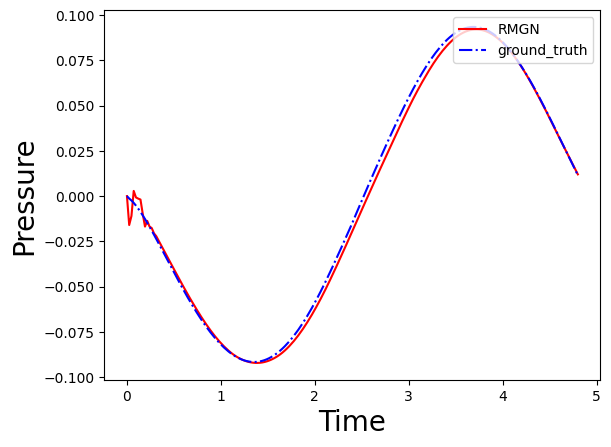

0.024920176601881394

In [30]:
# Plot prediction/ground truth
import matplotlib.pyplot as plt

def plot_comparison(model, data):
    n_edge = data.edge_attr.size(0)
    hidden = torch.zeros(n_edge, args.hidden_dim).to(args.device)
    _x = data.x
    edge_index = data.edge_index.to(args.device)
    _edge_attr = data.edge_attr

    total_loss = 0
    total_node_out = [data.pressure[:,0].unsqueeze(1)]
    total_edge_out = [data.velocity[:,0].unsqueeze(1)]
    for i in range(1, args.n_time):
        model.eval()
        with torch.no_grad():
            _pressure = data.pressure[:,i-1].unsqueeze(1)
            _velocity = data.velocity[:,i-1].unsqueeze(1)
            x = torch.cat([_x, _pressure], dim=1).to(args.device)
            edge_attr = torch.cat([_edge_attr, _velocity], dim=1).to(args.device)
            node_out, edge_out, hidden = model(x, edge_index, edge_attr, hidden)
            hidden = hidden.detach()

            loss = criterion(node_out, data.pressure[:,i].unsqueeze(1).float().to(args.device))
            loss += criterion(edge_out, data.velocity[:,i].unsqueeze(1).float().to(args.device))

            total_loss += loss.item()
            total_node_out.append(node_out.detach().cpu())
            total_edge_out.append(edge_out.detach().cpu())
    total_node_out = torch.cat(total_node_out, dim=1)
    total_edge_out = torch.cat(total_edge_out, dim=1)
    
    # plot
    node = 50000
    y_pred = total_node_out[node].numpy()
    y_true = data.pressure[node].numpy()
    x = [i * 4.8 /200 for i in range(201)]
    plt.plot(x, y_pred, c='red', label='RMGN')
    plt.plot(x, y_true, c='blue', linestyle='dashdot', label='ground_truth')
    # plt.ylim([-50,50])
    plt.legend(loc='upper right')
    plt.ylabel('Pressure', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.show()
    
    return total_loss
    
plot_comparison(model, dataset[40])